# Predicting NBA players' salaries
* Motivation and outline
* Data collection
* Variables
    * Salary
    * Independent Variable
* Setup Imports and Variables
* Explore the data
  *  Target feature: Salary
     * Reduce dimension by looking at correlation with salary:
  *  Input features
* Prediction
* Model Checking
* Summary of findings
* References

## Motivation and outline:

Are NBA palyers' salaries comparable to his market value?  Are any NBA players paid equal to the market for their services? More interestingly, what factors explain how salaries are set in the NBA?

In this notebook, I seek to answer these questions.
* Part 1 will discuss the factors that explain factors in NBA 
* Part 2 will analyze the results of that model and present the expected salaries of NBA players using 2017-18 season statistics to explain their 2018-19 salaries.
* Part 3 will will present the results of this analysis and predict the expected salaries of players for the 2019-20 season. (To be done some time in the near future)


## Data collection:

To answer the NBA Salary question,I collected salary and performance data from  https://www.basketball-reference.com <br> using BeautifulSoup module. 
* See player_dict for a list of player urls 
* See get_data.py and player_url.py for web scrapping details

Since I use data that spans two seasons, I restricted the set to players who played in both the 2017-18 and 2018-19 seasons. Also, I restricted players who earned at least $100k during the 2017-18 season as too low salaries are outliers.

Players signed contracts in different years.  The value of the contract only reflects the value at the time they signed the contract.I adjusted all contracts by adjusting the contracts proportional to the difference in the current salary cap and the salary cap of the first year the contract is effective.  

**Regulations (e.g., the salary cap, max contracts, the super max, minimum salaries, the rookie wage scale, etc.) affect the wage setting structure in the NBA.  I need to reconduct analysis taking all these factors into account.**

## Variables

### Salary:

Salary is the dependent variable. As stated above, I adjusted the salary data accounting for the increasing salary cap. **I will also apply adjustments to take away the effect of various regulations in future analysis.**

### Independent variables: 

I chose the following player variables that could be correlated with the salary. I will list questions I want to explore and answer them in the analysis in later parts. No team factor needs to be added as the NBA salary cap and luxury tax system has already forced all teams to pay on the same scale. 

*    **Years in the League**

The number of years a player has played in the NBA accounts for how salaries change as players progress in their careers.  It makes sense to believe the longer a player plays in the NBA the higher the salary is? 

*    **Minutes per Game**

Players who play the most in the court should be compensated best? Usually, those who play the longest should be the best performers and hence earn highest salary?

*    **Points per 36 Minutes**

This measures the scoring ability of a player. A higher scoring ability should mean high salary?

*    **Usage rate**

This is an estimate of the percentage of team plays used by a player while he was on the floor. This is another measurement of the scoring ability of a player. Including both points per 36 minutes and usage rate would lead to the problem of multicollineairty. I will select the one with higher correlation with salary.

*    **NBA All star**

NBA All stars are effectively the best performing player in the league selected by the coaches. It makes sense that they should earn more than the other players?

We also need to include the boxscores. Rather than including steals, blocks, assits, rebounds etc separately. I opt for some overall metrics. Below are 4 I chose on the offensive and defensive end. I probably just need one pair from them , will make selection based on correlation.

*    **Offensive Win Shares**

A metric that estimates the number of wins a player produces for his team offensively.**


*    **Defensive Win Shares**

A metric that estimates the number of wins a player produces for his team defensively.**


*    **Obpm**

Offensive box plus/minus, it takes offensive box score stats from an individual and team level and tries estimate player performance relative to NBA average.

*    **Dbpm-- Defensive box plus/minus, same as above , but for defensive performance.**

In [2]:
from get_data import data
import pickle

dataframe=data()

dataframe=dataframe[dataframe['Salary']>=100000]
dataframe=dataframe.reset_index()
dataframe=dataframe.drop(['index'],axis=1)

#save the dataframe as a pickle object

with open ('player_dataframe', 'wb') as fw:
    pickle.dump(dataframe, fw)

## Setup Imports and Variables

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import pickle
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(10, 5))

# Size of matplotlib figures that contain subplots
fizsize_with_subplots = (10, 10)

# Size of matplotlib histogram bins
bin_size = 10

## Explore the data

Read the data:

In [2]:
with open ('player_dataframe', 'rb') as fw:
    df=pickle.load(fw)
    
df.head()

,Player_name,Years in League,Minutes per Game,Points per 36 minutes,NBA ALL STAR,Usage Rate,Offensive Win Share,Defensive Win Share,Obpm,Dbpm,Salary
0,Alex Abrines,2.0,15.5,13.9,0.0,15.9,1.2,0.9,-0.3,-2.2,5.885381e+06
1,Quincy Acy,6.0,14.7,14.3,0.0,16.8,0.5,0.5,-1.8,-1.2,1.757429e+06
2,Steven Adams,5.0,29.9,13.6,0.0,16.2,3.3,3.1,-0.7,1.2,2.310144e+07
3,Arron Afflalo,11.0,25.9,11.7,0.0,14.4,1.2,0.2,-1.4,-2.1,1.542021e+06
4,Cole Aldrich,8.0,8.6,7.1,0.0,9.4,0.6,0.7,-2.0,2.6,7.504503e+06


In [3]:
df.tail()

,Player_name,Years in League,Minutes per Game,Points per 36 minutes,NBA ALL STAR,Usage Rate,Offensive Win Share,Defensive Win Share,Obpm,Dbpm,Salary
294,Delon Wright,3.0,16.5,12.1,0.0,16.6,0.5,0.6,-0.1,1.2,1.691289e+06
295,Nick Young,11.0,25.9,18.3,0.0,19.5,3.0,0.2,2.7,-3.4,5.337449e+06
296,Thaddeus Young,11.0,30.2,13.1,0.0,16.4,2.0,2.7,0.0,1.4,1.521085e+07
297,Cody Zeller,5.0,27.8,13.3,0.0,15.5,3.4,2.2,-0.2,2.3,1.293681e+07
298,Tyle Zeller,6.0,10.3,12.2,0.0,16.5,0.5,0.6,-3.3,0.8,1.757429e+06


View the data types of each column:


In [4]:
df.dtypes

Player_name               object
Years in League          float64
Minutes per Game         float64
Points per 36 minutes    float64
NBA ALL STAR             float64
Usage Rate               float64
Offensive Win Share      float64
Defensive Win Share      float64
Obpm                     float64
Dbpm                     float64
Salary                   float64
dtype: object

Check if there is missing value

In [5]:
df.isnull().sum().sort_values(ascending=False).head(20)

#There is no missing value at all

Salary                   0
Dbpm                     0
Obpm                     0
Defensive Win Share      0
Offensive Win Share      0
Usage Rate               0
NBA ALL STAR             0
Points per 36 minutes    0
Minutes per Game         0
Years in League          0
Player_name              0
dtype: int64

Get some basic information on the DataFrame:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 11 columns):
Player_name              299 non-null object
Years in League          299 non-null float64
Minutes per Game         299 non-null float64
Points per 36 minutes    299 non-null float64
NBA ALL STAR             299 non-null float64
Usage Rate               299 non-null float64
Offensive Win Share      299 non-null float64
Defensive Win Share      299 non-null float64
Obpm                     299 non-null float64
Dbpm                     299 non-null float64
Salary                   299 non-null float64
dtypes: float64(10), object(1)
memory usage: 25.8+ KB


Generate various descriptive statistics on the DataFrame:

In [7]:
df.describe()

,Years in League,Minutes per Game,Points per 36 minutes,NBA ALL STAR,Usage Rate,Offensive Win Share,Defensive Win Share,Obpm,Dbpm,Salary
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,2.990000e+02
mean,7.454849,23.754515,15.282609,0.193980,19.384281,2.017391,1.661873,-0.293980,-0.021405,9.597678e+06
std,3.821583,7.898242,4.917333,0.396076,5.500353,2.335235,1.098268,2.621932,1.868085,8.209165e+06
min,2.000000,3.400000,2.100000,0.000000,8.800000,-1.400000,0.000000,-9.600000,-6.100000,1.031643e+05
25%,4.000000,17.700000,11.550000,0.000000,15.250000,0.450000,0.900000,-1.900000,-1.350000,2.544965e+06
50%,7.000000,24.500000,14.600000,0.000000,19.100000,1.300000,1.500000,-0.400000,-0.100000,6.986504e+06
75%,10.000000,30.350000,18.250000,0.000000,22.650000,2.750000,2.300000,0.700000,1.200000,1.479055e+07
max,20.000000,37.800000,32.900000,1.000000,41.700000,11.500000,6.000000,10.900000,5.600000,3.565415e+07


### Target feature: Salary

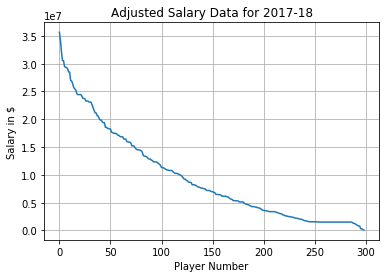

In [8]:
salary=df['Salary']
salary = sorted (salary, reverse=True)
plt.plot(range(len(salary)),salary)
plt.title('Adjusted Salary Data for 2017-18')
plt.xlabel('Player Number')
plt.ylabel('Salary in $')
plt.grid()
plt.show()

I am going to fit a linear model. Do we need to transform the salary data? 

Yes we do!!

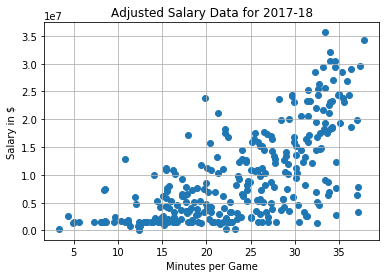

In [9]:
df.sort_values(by='Minutes per Game')
salary=df['Salary']
minutes_per_game = df['Minutes per Game']
plt.scatter(minutes_per_game,salary)
plt.title('Adjusted Salary Data for 2017-18')
plt.xlabel('Minutes per Game')
plt.ylabel('Salary in $')
plt.grid()
plt.show()

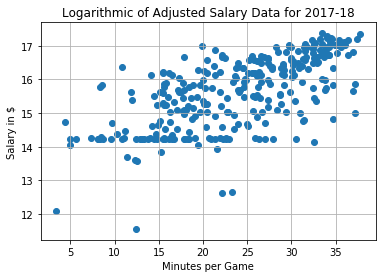

In [10]:
df.sort_values(by='Minutes per Game')
salary=np.log(df['Salary'])
minutes_per_game = df['Minutes per Game']
plt.scatter(minutes_per_game,salary)
plt.title('Logarithmic of Adjusted Salary Data for 2017-18')
plt.xlabel('Minutes per Game')
plt.ylabel('Salary in $')
plt.grid()
plt.show()


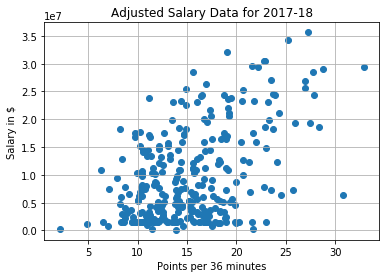

In [11]:
df.sort_values(by='Points per 36 minutes')
salary=df['Salary']
Points_per_36_minutes = df['Points per 36 minutes']
plt.scatter(Points_per_36_minutes,salary)
plt.title('Adjusted Salary Data for 2017-18')
plt.xlabel('Points per 36 minutes')
plt.ylabel('Salary in $')
plt.grid()
plt.show()

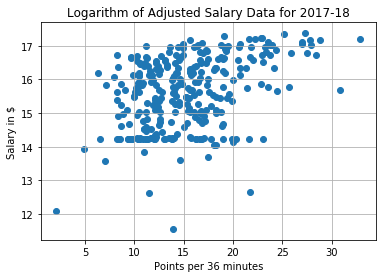

In [12]:
df.sort_values(by='Points per 36 minutes')
salary=np.log(df['Salary'])
Points_per_36_minutes = df['Points per 36 minutes']
plt.scatter(Points_per_36_minutes,salary)
plt.title('Logarithm of Adjusted Salary Data for 2017-18')
plt.xlabel('Points per 36 minutes')
plt.ylabel('Salary in $')
plt.grid()
plt.show()

The above plots shows log salary have a more linear relationship with the independent variables than salary itself. We can check if all the OLS constraints (normaility, uncorrelated error terms, same variance etc) by analysing the diagnostic plots.

### Reduce dimension by looking at correlation with salary : 

A few variables selected are correlated with each other (by definition of varaibles), so I will look at their individual correlation with target feature salary and just select one from the group of  correlated varaibles.

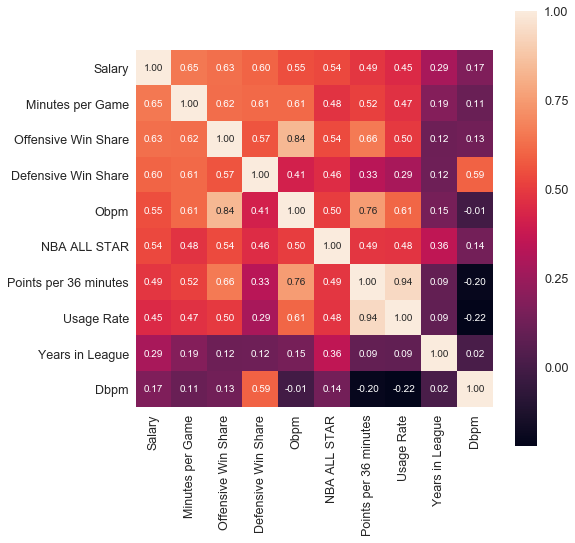

In [13]:
#drop player name
plt.figure(figsize=(8,8))
#df=df.drop(['Player_name'],axis=1)
corr=df.corr()
k = 11 #number of variables for heatmap
cols = corr.nlargest(k, 'Salary')['Salary'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

There is a high correlation between points per 36 minutes and usage rate (0.94) since players need to use possessions in order to score, which means that including both variable would introuce high collinearity and we actually just need one. As points per 36 minutes have higher correlation with salary, I decide just to include it.

Also, there is high correlation between Offensive Win Share and Obpm and also Defensive Win Share and Dbpm, and win shares have higher correlation with salaries so i decide just to use winshares.

In [14]:
#drop duplicated features

df=df.drop(['Player_name', 'Usage Rate','Obpm','Dbpm'],axis=1)

### Input features: 

*    Years in the League
*    Minutes per Game
*    Points per 36 Minutes
*    Offensive Win Shares 
*    Defensive Win Shares 
*    NBA All star 


**Before we build the linear model, let us dig a bit more into the variables to see if we need to include higher order terms.**

### Years in the League

To analyse the years in the league on salary, one needs to fix a player and fix all other variables approximatley the same. I did not scrap salaries of a player over many years. So I will borrow the conclusion from [2].

![title](Years-of-Experience-Curve.jpg)

The number of years a player has played in the NBA accounts for how salaries change as players progress in their careers. The longer a player plays in general, the longer the salary. This is true on avaerage only up to ten years. Because the salary is more correlated with performance. Players improve until they hit their prime.  After that, their performance will decline.

The above is only true for an average player, if you are someone like leborn or tony parker, who have earned titles of nba all star players multiple times, you will still earn high salaries when you are 15 years into your career. This is an attribute to your past performance more or less. However, the salary you earn will also depend on your current ability with Lebron earning threee times as more as Tony Parker because his current much superior performance.

To account for the above curve shape, I added years in the leauge squared to my model.

### Other indepedent variables

Upon inspection, all other variables seem to have a linear relationship with the data so there is no need to include higher order terms.

## Prediction


I will create a linear model using all input features to try to predict salary. To account for the aging effect, not only do I include the number of years a player has played in the NBA as a variable but I also include the squared term.  The squared term allows us to model the aging effect. 

In [15]:
#normalise all input data

from sklearn import preprocessing
import pandas

df['Log_Salary']= np.log(df['Salary'])
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pandas.DataFrame(x_scaled)

In [18]:
df.columns=['Years_in_League','Minutes_Per_Game','Points_per_36_Minutes','NBA_ALL_STAR','Offensive_Win_Share','Defensive_Win_Share','Salary','Log_Salary']
df['Years_in_League_Squared']=df['Years_in_League']**2


In [24]:
results = smf.ols("Log_Salary ~ Years_in_League+Years_in_League_Squared+Minutes_Per_Game+Points_per_36_Minutes+NBA_ALL_STAR+Offensive_Win_Share+Defensive_Win_Share", data=df).fit() 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Salary   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     47.88
Date:                Mon, 03 Jun 2019   Prob (F-statistic):           6.38e-45
Time:                        00:57:08   Log-Likelihood:                 201.70
No. Observations:                 299   AIC:                            -387.4
Df Residuals:                     291   BIC:                            -357.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

At 1 percent signficane, we can conclude Years in League, Years in League Sqaured, Minutes Per Game, Defensive Win Share are significant in explaining salary. Maybe minutes per game is probably a good enough indicator for the offensive ability of a player while the Defensive Win Share shows the defensive ability of the player. And together they are sufficient to show player's performance?

My model is able to explain 53% of the total variance in the training set. The unexplained variance might be due to rookie salary or other regulation factors that I have not taken into account.

## Model checking

As stated above, need to check if our assumption for the normal linear model make sense. Below I included a few R-style diagnostic plots, code adapted from [3].

In [26]:
model_fit = results

# fitted values (need a constant term for intercept)
model_fitted_y = model_fit.fittedvalues

# model residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

**Residaul vs Fitted**

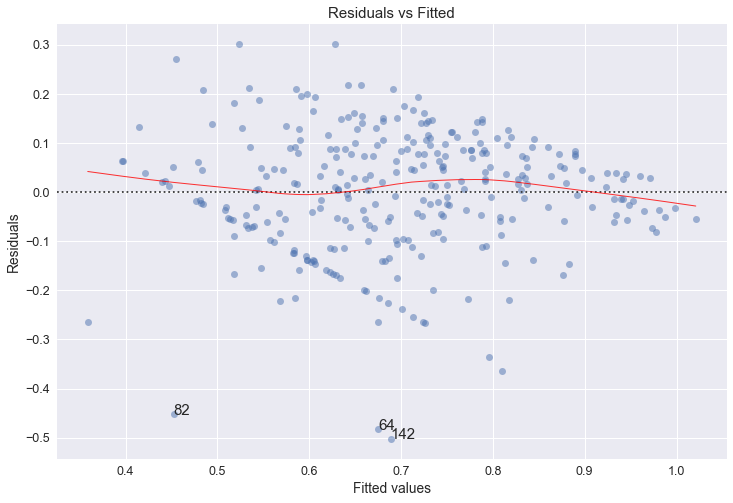

In [28]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'Log_Salary', data=df, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:3]

for i in abs_resid_top_3.index:
    plot_lm_1.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_residuals[i]));

The residuals "bounce randomly" around the 0 line. This suggests that the assumption that the relationship is linear is reasonable.

The variation of the residual seems to vary with the fitted value. This seems to suggest the problem of heteroscadicity-- the variances of the error terms are not equal.

Three residuals "stands out" from the basic random pattern of residuals. They might be outliers.

**Normal QQ Plot**

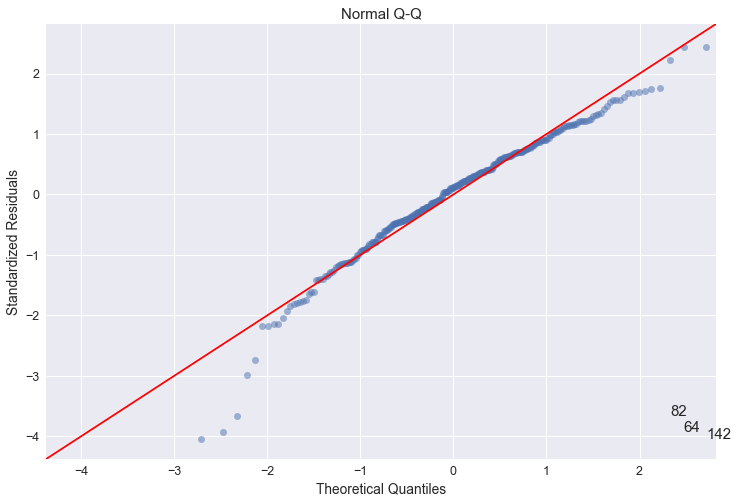

In [31]:
from statsmodels.graphics.gofplots import ProbPlot
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

The residual largely equals the theoretical quantiles suggesting the normality assumption holds.

**Scale Location Plot**

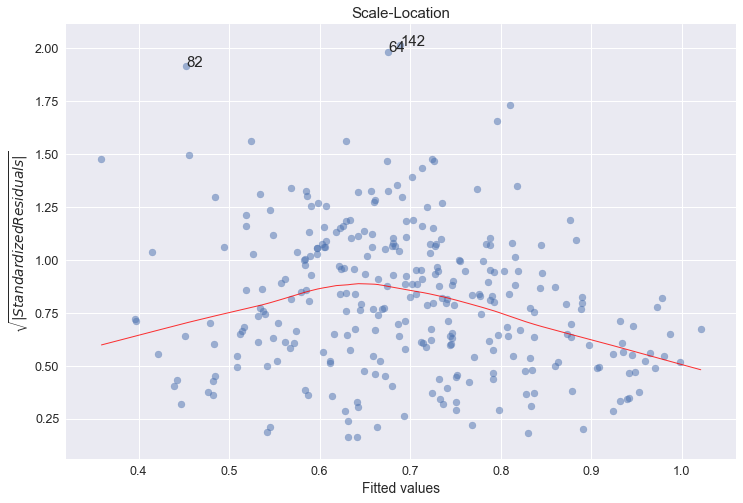

In [32]:
plot_lm_3 = plt.figure(3)
plot_lm_3.set_figheight(8)
plot_lm_3.set_figwidth(12)

plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_norm_residuals_abs_sqrt[i]));

The red line is not horizontal -- hetereoskedasticity 

The spread around the red line varies with the fitted values and there appear to be outliers.

**Leverage plot**

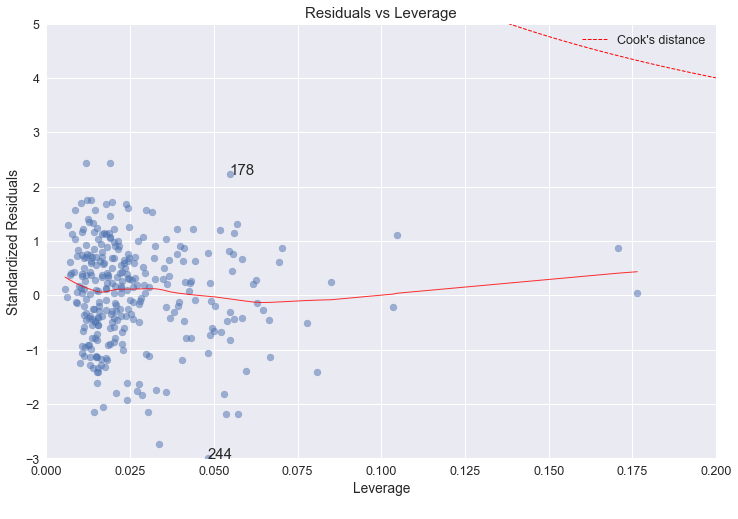

In [33]:
plot_lm_4 = plt.figure(4)
plot_lm_4.set_figheight(8)
plot_lm_4.set_figwidth(12)

plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_4.axes[0].set_xlim(0, 0.20)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, 
                               xy=(model_leverage[i], 
                                   model_norm_residuals[i]))
    
# shenanigans for cook's distance contours
def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

p = len(model_fit.params) # number of model parameters

graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance') # 0.5 line
graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50)) # 1 line
plt.legend(loc='upper right');

Basing on Cook's distance, there are no very influential points.

## Summary of finding

In this notebook, my aim is to identify the variables that are important to explain nba players' salaries and build models to predict salaries. I scraped data online, clean, visualise data and use it for prediction.

The most important variables in explaining nba players' salaries are:
Years_in_League,Minutes_Per_Game,Defensive_Win_Share

For years in league, salary is quadratic in it. Players salaries are closely linked with their performance. Their performance on average continue to improve until thir prime (which is around 10th year in the league).

For the other variables, salary has largely a linear relationship with them. Among those, minutes per game, offensive win share and defensive win share seem to be the most significant factors as they bear the highest correlation with salary.

The diagnostic plots suggest that the normality and linear assumptions of the normal linear model hold but the variance term seems to be non constant and vary with y. This suggests we need a better linear model with more terms to explain the variance, e.g. rescaling salary to include effect of rookie wage, max wage, min wage etc.

## References:

1. https://en.wikipedia.org/wiki/NBA_salary_cap
2. https://prosportsanalytics.com/2017/05/25/predicting-nba-salaries-part-1/
3. https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034